In [1]:
import random
import os
from itertools import combinations
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import pearsonr, spearmanr

In [2]:
repo_dir = "/Users/ameliachu/repos/nlu-reddit-toxicity-dataset"
data_dir = f"{repo_dir}/data"

In [3]:
labelled_data_file_name = "labelled_master_data_2022-04-18.csv"
labelled_data_location = f"{data_dir}/{labelled_data_file_name}"

In [4]:
figures = {}
tables = {}

In [5]:
labelled_data = pd.read_csv(labelled_data_location)

In [6]:
labelled_data.head(5)

,example_id,preceding_comment,comment_for_evaluation,following_comment,toxicity,severe_toxicity,identity_attack,insult,profanity,threat
0,104857,[https://www.youtube.com/watch?v=hRBOnA0ak4w&a...,GME just watching this all and doing nothing lol,[https://www.youtube.com/watch?v=hRBOnA0ak4w&a...,0,0,0,0,0,0
1,105125,#GOTTA GET THAT 1.48% ON A BOND WHOOOO,"Everything is down today, knee jerk reaction t...","AMC, I held all this time and I decided to buy...",0,0,0,0,0,0
2,105684,Having 30k to lose sounds pretty nice to me,"No, this is the Warthog",a good trump tweet would turn all this carnage...,0,0,0,0,0,0
3,105904,His tools for inflation are literally rates an...,The market is not worth what you guys have bee...,Can somebody make clear that it's not us who a...,0,0,0,0,0,0
4,1138,Wot?,Didnt he sell all his shares?,This is the way lol holding 100 March 12 / $51...,0,0,0,0,0,0


In [7]:
labelled_data.count()[0]

800

In [8]:
examples_with_missing_labels = labelled_data[labelled_data.isna().any(axis=1)]['example_id']

In [9]:
labelled_data[labelled_data.isna().any(axis=1)]

,example_id,preceding_comment,comment_for_evaluation,following_comment,toxicity,severe_toxicity,identity_attack,insult,profanity,threat


In [143]:
36221, 267142, 301490 = ac4119
yj2369 = 98710
gm2858 = 210983

SyntaxError: cannot assign to literal (<ipython-input-143-9aced54a941d>, line 1)

In [10]:
labels = ['toxicity', 'severe_toxicity', 'identity_attack', 'insult', 'profanity', 'threat']

In [11]:
overall_count = pd.DataFrame([{'data_label': 'overall',
               'number_of_examples': labelled_data.count()[0]}])
by_label_count = labelled_data.agg({l:sum for l in labels}).reset_index()
by_label_count.columns = ['data_label','number_of_examples']

tables['label_distribution'] = pd.concat([overall_count,by_label_count ]).reset_index(drop=True)

In [12]:
tables['label_distribution'] 

,data_label,number_of_examples
0,overall,800
1,toxicity,23
2,severe_toxicity,3
3,identity_attack,9
4,insult,49
5,profanity,113
6,threat,0


In [15]:
tables['label_corr'] = labelled_data[labels].corr('pearson')

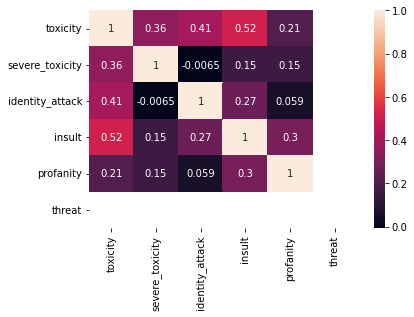

In [17]:
figures['label_corr'] = sns.heatmap(tables['label_corr'], annot=True)
figures['label_corr']

In [18]:
interrater_dir = f"{data_dir}/interrater-reliability"

In [19]:
interrater_files = [f for f in os.listdir(interrater_dir) if f.startswith('interrater2') ]

In [20]:
interrater_info = {}
for file in interrater_files:
    file_type, rater_id, date_rated = file.split('.')[0].split('-')
    data_path = f'{interrater_dir}/{file}'
    interrater_info[rater_id] = {
        "data": pd.read_csv(data_path),
        "created_date": date_rated,
        "file_path": data_path
                          }

In [21]:
raters = list(interrater_info.keys())
random.shuffle(raters)

In [22]:
num_raters = len(raters)
all_rater_combinations = list(combinations(range(num_raters), 2))

In [23]:
interrater_assessments = []
labels = ['toxicity', 'severe_toxicity', 'identity_attack', 'insult', 'profanity', 'threat']
selected_columns = ['example_index','comment_for_evaluation'] + labels

for i, rater_id in enumerate(raters):
    individual_ratings = interrater_info[rater_id]['data'][selected_columns]
    interrater_assessment = pd.melt(individual_ratings,
                                    id_vars=['example_index'], 
                                    value_vars=labels)\
                              .rename(columns={'value':'label'})
    # Using file id instead of rater_id to anonymize results
    interrater_assessment["file_id"] = i
    interrater_assessments.append(interrater_assessment)

In [24]:
interrater_assessments_df = pd.concat(interrater_assessments)
interrater_assessments_df = pd.pivot(interrater_assessments_df, 
                                     index=['variable', 'example_index'], 
                                     columns='file_id', values='label').fillna(0).reset_index()

In [25]:
spearmanr_reliability = []
for rater_x, rater_y in all_rater_combinations:
    r_coef, p_value = spearmanr(interrater_assessments_df[rater_x].values, interrater_assessments_df[rater_y].values)
    data = {"rater_pair": (rater_x, rater_y), "r_coef": r_coef, "p_value": p_value, "spearmanr_reliability_type":"overall"}
    spearmanr_reliability.append(data)

    for variable in interrater_assessments_df['variable'].unique():
        rater_x_values = interrater_assessments_df[interrater_assessments_df['variable']==variable][rater_x].values
        rater_y_values = interrater_assessments_df[interrater_assessments_df['variable']==variable][rater_y].values
        var_r_coef, var_p_value = spearmanr(rater_x_values, rater_y_values)
        data = {"rater_pair": (rater_x, rater_y), "r_coef": var_r_coef, "p_value": var_p_value, 
                "spearmanr_reliability_type":f"by_var_{variable}"}
        spearmanr_reliability.append(data)

/Users/ameliachu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [26]:
spearmanr_reliability_df = pd.DataFrame(spearmanr_reliability)[['spearmanr_reliability_type', 'rater_pair', 'r_coef','p_value']].fillna(1)

In [27]:
spearmanr_reliability_df.groupby('spearmanr_reliability_type').agg({'r_coef':np.mean}).reset_index()

,spearmanr_reliability_type,r_coef
0,by_var_identity_attack,0.800000
1,by_var_insult,0.853553
2,by_var_profanity,0.800000
3,by_var_severe_toxicity,0.938743
4,by_var_threat,1.000000
5,by_var_toxicity,0.500000
6,overall,0.710046


In [ ]:
Label Type Interrater Reliability (Spearmann)